## Overview

This notebook trains a U-Net deep learning model for multi-class semantic segmentation using the DeepGlobe Land Cover Classification dataset.

Because the original satellite images are very large (2448×2448), images and masks are resized to 512×512 during loading to make training computationally feasible. This is a standard practice in remote-sensing deep learning pipelines.

In [8]:
import os
from pathlib import Path

import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

## Section 1 - Device Configuration

We explicitly check whether CUDA is available and train on GPU if possible.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 2050


In [10]:
PROJECT_ROOT = Path("..")
TRAIN_DIR = PROJECT_ROOT / "data" / "raw" / "train"

assert TRAIN_DIR.exists(), f"Train directory not found: {TRAIN_DIR}"
print("Train directory verified:", TRAIN_DIR.resolve())

Train directory verified: C:\Users\ibaan\Documents\Coding\Python\deepglobe_segmentation\data\raw\train


## Section 2 - Mask Color → Class Mapping

DeepGlobe masks are RGB images where each land-cover class is encoded by a color.
We convert these RGB values into integer class labels (0–6).

In [11]:
COLOR_MAP = {
    (0, 255, 255): 0,    # Urban
    (255, 255, 0): 1,    # Agriculture
    (255, 0, 255): 2,    # Rangeland
    (0, 255, 0): 3,      # Forest
    (0, 0, 255): 4,      # Water
    (255, 255, 255): 5,  # Barren
    (0, 0, 0): 6         # Unknown
}

def rgb_to_class(mask_rgb):
    h, w, _ = mask_rgb.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)

    for rgb, cls in COLOR_MAP.items():
        matches = np.all(mask_rgb == np.array(rgb), axis=-1)
        class_mask[matches] = cls

    return class_mask

print("Color map for segmentation classes defined.")

Color map for segmentation classes defined.


## Section 3 - Dataset Class

This dataset:
- Loads satellite images and corresponding masks
- Converts RGB masks into class indices
- Resizes images and masks to 512×512
- Returns PyTorch tensors ready for training

In [19]:
class DeepGlobeDataset(Dataset):
    def __init__(self, data_dir, image_files):
        self.data_dir = data_dir
        self.image_files = image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        mask_name  = image_name.replace("_sat.jpg", "_mask.png")

        image_path = self.data_dir / image_name
        mask_path  = self.data_dir / mask_name

        # Load image
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(str(mask_path))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = rgb_to_class(mask)

        # Convert to tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        mask  = torch.tensor(mask, dtype=torch.long)

        # Resize to 512×512
        image = F.interpolate(
            image.unsqueeze(0),
            size=(512, 512),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        mask = F.interpolate(
            mask.unsqueeze(0).unsqueeze(0).float(),
            size=(512, 512),
            mode="nearest"
        ).squeeze().long()

        return image, mask

## Section 4 - Train / Validation Split

We split the 803 samples into 80% training and 20% validation.
This replaces the missing labeled validation set.

In [20]:
all_images = sorted([
    f for f in os.listdir(TRAIN_DIR)
    if f.endswith("_sat.jpg")
])

print("Total images:", len(all_images))

train_files, val_files = train_test_split(
    all_images,
    test_size=0.2,
    random_state=42
)

print("Train samples:", len(train_files))
print("Val samples  :", len(val_files))

Total images: 803
Train samples: 642
Val samples  : 161


# DataLoaders 
On Windows, num_workers=0 is used to avoid multiprocessing crashes.

In [21]:
train_dataset = DeepGlobeDataset(TRAIN_DIR, train_files)
val_dataset   = DeepGlobeDataset(TRAIN_DIR, val_files)

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Data Sanity Check
Before training, we verify that one batch loads correctly.

In [22]:
images, masks = next(iter(train_loader))

print("Image shape:", images.shape)
print("Mask shape :", masks.shape)
print("Image dtype:", images.dtype)
print("Mask dtype :", masks.dtype)
print("Mask classes:", torch.unique(masks))

Image shape: torch.Size([2, 3, 512, 512])
Mask shape : torch.Size([2, 512, 512])
Image dtype: torch.float32
Mask dtype : torch.int64
Mask classes: tensor([0, 1, 5])


## Section 5 - U-Net Model

We use a standard U-Net architecture suitable for multi-class segmentation.

In [23]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = block(3, 64)
        self.enc2 = block(64, 128)
        self.enc3 = block(128, 256)
        self.enc4 = block(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = block(128, 64)

        self.out = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b  = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out(d1)

# Training Setup

We use:
- CrossEntropyLoss for multi-class segmentation
- Adam optimizer
- A small learning rate for stable convergence

In [24]:
model = UNet(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print("Model, loss function, and optimizer initialized.")

Model, loss function, and optimizer initialized.


# Training Loop

We first run a short training to confirm everything works.
Loss values should decrease gradually.

In [25]:
epochs = 1  # sanity run

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch {epoch+1} | Batch {i}/{len(train_loader)} | Loss {loss.item():.4f}")

    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1} completed | Avg Train Loss: {train_loss:.4f}")

Epoch 1 | Batch 0/321 | Loss 1.9734
Epoch 1 | Batch 10/321 | Loss 1.8398
Epoch 1 | Batch 20/321 | Loss 1.7520
Epoch 1 | Batch 30/321 | Loss 2.2123
Epoch 1 | Batch 40/321 | Loss 2.0209
Epoch 1 | Batch 50/321 | Loss 1.3034
Epoch 1 | Batch 60/321 | Loss 1.4134
Epoch 1 | Batch 70/321 | Loss 1.5482
Epoch 1 | Batch 80/321 | Loss 1.4625
Epoch 1 | Batch 90/321 | Loss 1.7419
Epoch 1 | Batch 100/321 | Loss 1.5776
Epoch 1 | Batch 110/321 | Loss 1.1293
Epoch 1 | Batch 120/321 | Loss 1.3954
Epoch 1 | Batch 130/321 | Loss 1.0369
Epoch 1 | Batch 140/321 | Loss 1.6145
Epoch 1 | Batch 150/321 | Loss 1.0903
Epoch 1 | Batch 160/321 | Loss 2.4543
Epoch 1 | Batch 170/321 | Loss 2.6113
Epoch 1 | Batch 180/321 | Loss 0.8318
Epoch 1 | Batch 190/321 | Loss 1.5472
Epoch 1 | Batch 200/321 | Loss 1.4376
Epoch 1 | Batch 210/321 | Loss 0.6600
Epoch 1 | Batch 220/321 | Loss 1.4986
Epoch 1 | Batch 230/321 | Loss 1.6637
Epoch 1 | Batch 240/321 | Loss 1.2168
Epoch 1 | Batch 250/321 | Loss 2.1065
Epoch 1 | Batch 260/321

In [26]:
train_losses = []
val_losses = []

In [28]:
from tqdm import tqdm

from tqdm import tqdm

epochs = 10

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{epochs} - Training",
        leave=False
    ):
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(
            val_loader,
            desc=f"Epoch {epoch+1}/{epochs} - Validation",
            leave=False
        ):
            images = images.to(device)
            masks  = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )


Epoch 1/10 | Train Loss: 1.2666 | Val Loss: 1.2218


Epoch 2/10 | Train Loss: 1.1583 | Val Loss: 1.0457


Epoch 3/10 | Train Loss: 1.1083 | Val Loss: 1.0390


Epoch 4/10 | Train Loss: 1.0543 | Val Loss: 0.9923


Epoch 5/10 | Train Loss: 1.0313 | Val Loss: 0.9926


Epoch 6/10 | Train Loss: 1.0246 | Val Loss: 0.9738


Epoch 7/10 | Train Loss: 1.0048 | Val Loss: 1.0033


Epoch 8/10 | Train Loss: 1.0016 | Val Loss: 0.9844


Epoch 9/10 | Train Loss: 0.9848 | Val Loss: 0.9367


Epoch 10/10 | Train Loss: 0.9642 | Val Loss: 0.8952


## Section 6 - Training Results and Model Saving

After completing model training, we visualize the learning behaviour using loss curves and save the trained model for later evaluation and inference.

These steps are essential for:
- Verifying model convergence
- Detecting overfitting or underfitting
- Reusing the trained model without retraining

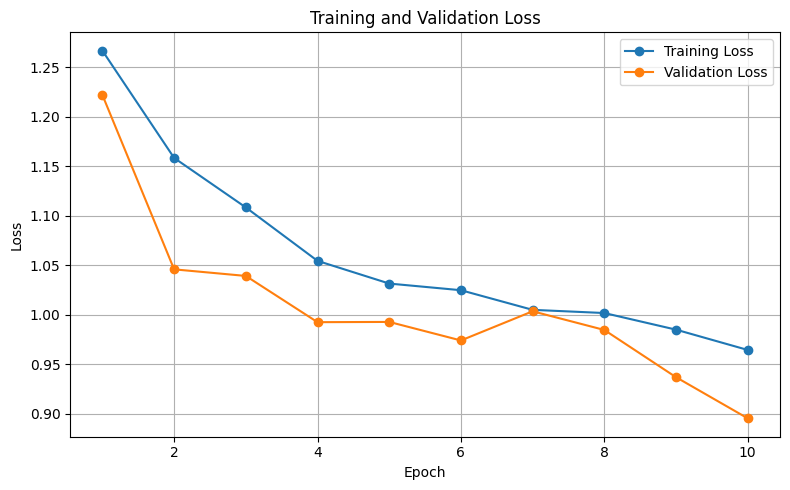

In [29]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, marker="o", label="Training Loss")
plt.plot(epochs_range, val_losses, marker="o", label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Saving the Trained Model

The trained U-Net model is saved to disk so that it can be reused for evaluation, inference, or deployment without retraining.

In [32]:
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True)

MODEL_PATH = MODELS_DIR / "unet_deepglobe.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "num_classes": 7,
    "input_size": (512, 512)
}, MODEL_PATH)

print(f"Model saved to: {MODEL_PATH}")

Model saved to: ..\models\unet_deepglobe.pth


# Saving Training History (Optional)

Loss values are saved to disk for reproducibility and future analysis.

In [34]:
import numpy as np

np.save(OUTPUT_DIR / "train_losses.npy", np.array(train_losses))
np.save(OUTPUT_DIR / "val_losses.npy", np.array(val_losses))

print("Training history saved.")

Training history saved.
